Téléchargement base de données + préprocessing

In [ ]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz > /dev/null 2>&1
!tar zxvf imagenette2.tgz > /dev/null 2>&1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch
import os
from torch.utils.data import Dataset

means, stds = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
    ])

test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
    ])

def get_imagenette2_loaders(root_path='./imagenette2', **kwargs):

    trainset = torchvision.datasets.ImageFolder(os.path.join(root_path, "train"), transform=train_transform)
    trainloader = torch.utils.data.DataLoader(trainset, **kwargs)
    testset = torchvision.datasets.ImageFolder(os.path.join(root_path, "val"), transform=test_transform)
    testloader = torch.utils.data.DataLoader(testset, **kwargs)
    return trainloader, testloader

trainloader, testloader = get_imagenette2_loaders( batch_size=64, shuffle=True, num_workers=2)

labels = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(-0.5, 1809.5, 453.5, -0.5)

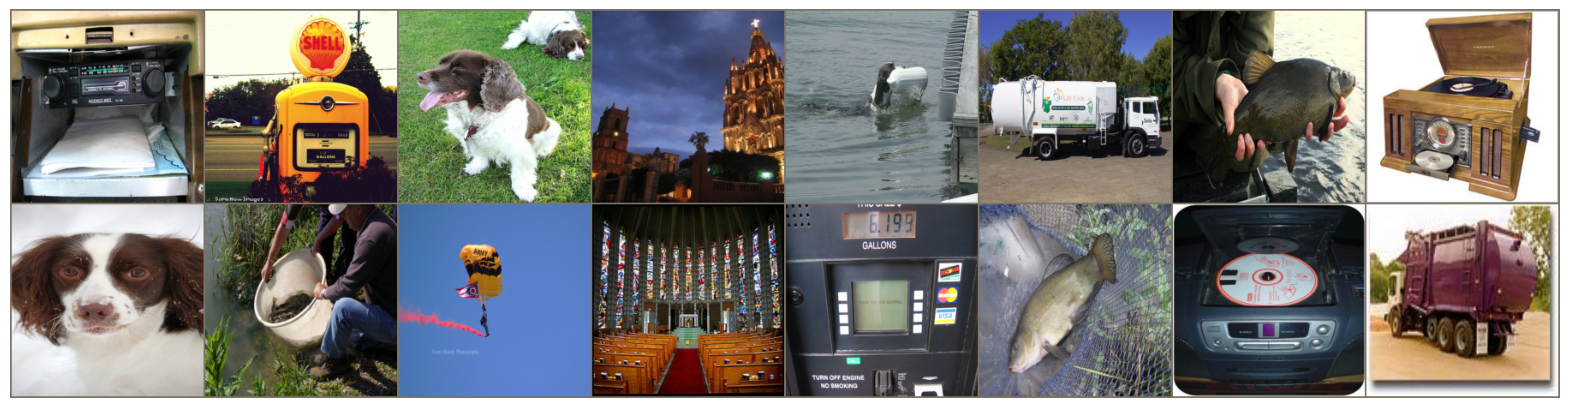

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(means, stds)],
   std= [1/s for s in stds]
)

x, _ = next(iter(trainloader))
img_grid = make_grid(x[:16])
img_grid = inv_normalize(img_grid)
plt.figure(figsize=(20,15))
plt.imshow(img_grid.permute(1, 2, 0))
plt.axis('off')

Modèle 1 : pr-trained VGG11

In [ ]:
import torch.nn as nn
import torch

model = torchvision.models.vgg11(pretrained=True)
for param in model.features:
    param.requires_grad = False

model.classifier = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=10, bias=True),
        )

model = model.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:05<00:00, 96.3MB/s]


In [ ]:
from tqdm import tqdm

criterion_classifier = nn.CrossEntropyLoss(reduction='mean')

def train(model, optimizer, trainloader, epochs=30):
    t = tqdm(range(epochs))
    for epoch in t:
        corrects = 0
        total = 0
        for x, y in trainloader:
            loss = 0
            x = x.cuda()
            y = y.cuda()
            y_hat = model(x)

            loss += criterion_classifier(y_hat, y)
            _, predicted = y_hat.max(1)
            corrects += predicted.eq(y).sum().item()
            total += y.size(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f'epoch:{epoch} current accuracy:{round(corrects / total * 100, 2)}%')
    return (corrects / total)

In [ ]:
learning_rate = 5e-3
epochs = 1
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=learning_rate)
train(model, optimizer, trainloader, epochs=epochs)

epoch:0 current accuracy:88.67%: 100%|██████████| 1/1 [01:13<00:00, 73.84s/it]


0.8866828598584856

In [ ]:
def test(model, dataloader):
    test_corrects = 0
    total = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.cuda()
            y = y.cuda()
            y_hat = model(x).argmax(1)
            test_corrects += y_hat.eq(y).sum().item()
            total += y.size(0)
    return test_corrects / total

model.eval()
test_acc = test(model, testloader)
print(f'Test accuracy: {test_acc:.2f} %')

Test accuracy: 0.95 %


Méthode 1 : RISE

In [ ]:
import numpy as np
from skimage.transform import resize


def generate_masks(N, s, p1, image_size):
    cell_size = np.ceil(np.array(image_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *image_size))

    for i in range(N):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear interpolation
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect', anti_aliasing=False)[x:x + image_size[0], y:y + image_size[1]]

    masks = masks.reshape(-1, 1, *image_size)
    masks = torch.from_numpy(masks).float()
    masks = masks.cuda()

    return masks

In [ ]:
def explain(model, N, p1, img, masks, gpu_batch=2):
      img = img.unsqueeze(0)
      print(masks.size())
      print(img.size())
      _, _, H, W = img.size()
      print(type(img), type(masks))

      stack = torch.mul(masks, img)

      p = []
      for i in range(0, N, gpu_batch):
          p.append(model(stack[i:min(i + gpu_batch, N)]))
      p = torch.cat(p)

      CL = p.size(1)
      sal = torch.matmul(p.data.transpose(0, 1), masks.view(N, H * W))
      sal = sal.view((CL, H, W))
      sal = sal / N / p1
      return sal



Model's prediction: English springer


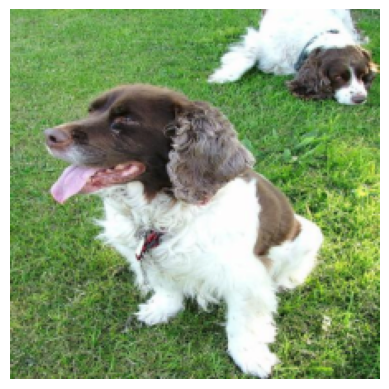

In [ ]:
# Visualisation de la importance map pour la prédiction du modèle VGG11 sur l'image suivante

idx = 2

img = inv_normalize(x[idx])
np_img = np.transpose(img.cpu().detach().numpy(), (1,2,0))*255
np_img = np_img.astype(np.uint8)
plt.imshow(np_img)
plt.axis('off')

input = x[idx].unsqueeze(0).cuda()
output = model(input)
_, prediction = torch.topk(output, 1)
print(f"Model's prediction: {labels[prediction.item()]}")

In [ ]:
N = 1000  # Number of masks
s = 8    # Size of grid
p1 = 0.5  # Probability of inclusion

masks = generate_masks(N, s, p1,  img.shape[-2:])

In [ ]:
saliency_maps = explain(model, N, p1, img.cuda(), masks)

plt.imshow(saliency_maps["French horn"], cmap='hot')
plt.colorbar()
plt.show()

torch.Size([1000, 1, 224, 224])
torch.Size([1, 3, 224, 224])
<class 'torch.Tensor'> <class 'torch.Tensor'>


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 4695 has 14.73 GiB memory in use. Of the allocated memory 14.16 GiB is allocated by PyTorch, and 428.94 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)